# Visualize Generator Outputs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

from torchgan.models import DCGANGenerator
from torch import nn
import torch

import numpy as np

import utils

### Load in the parameters 

In [3]:
GAN_PARAMS_TO_LOAD = 'wasserstein-loss-experiment-1.model'
GAN_CKPT_PATH = f'./model/{GAN_PARAMS_TO_LOAD}'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the meme background generator
generator_state_dict = torch.load(
    GAN_CKPT_PATH,
    map_location=torch.device(device)
)['generator']

generator = DCGANGenerator(
    encoding_dims=100,
    out_size=64,
    out_channels=3,
    step_channels=64,
    nonlinearity=nn.LeakyReLU(0.2),
    last_nonlinearity=nn.Tanh(),
).to(device).eval()

generator.load_state_dict(
    state_dict=generator_state_dict
)

<All keys matched successfully>

### Now we sample!

In [4]:
NUM_SAMPLES = 64

# normal
noise = generator.sampler(NUM_SAMPLES, device)[0]

# truncated normal
# noise = torch.fmod(torch.randn(NUM_SAMPLES, generator.encoding_dims),2)

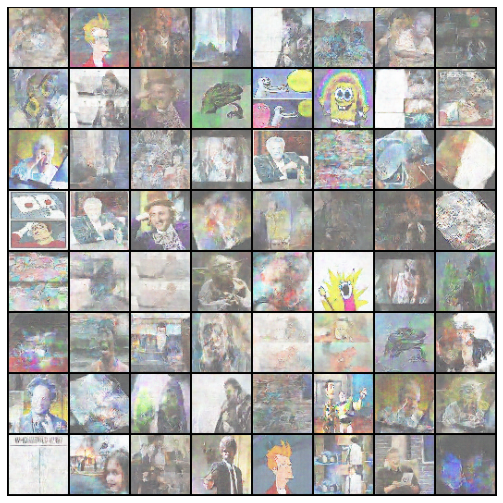

In [5]:
img = utils.tensor_to_image(generator(noise), ncol=8)

figure = plt.figure(figsize=(9, 9))
plt.imshow(np.asarray(img))
plt.axis('off')
plt.show()

#### We can (linearly) interpolate between two points in Z-space

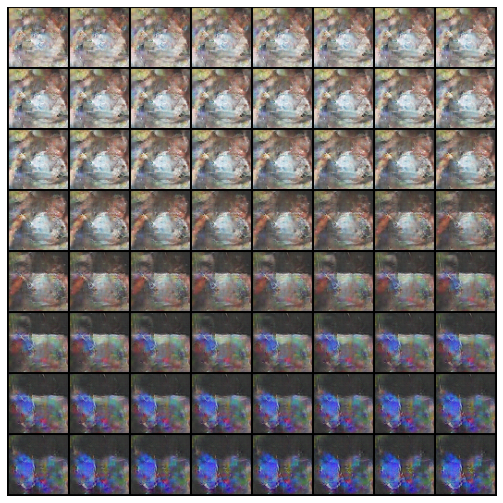

In [6]:
interpolated_noise = utils.interpolate(noise[0], noise[63])  # just two random start, end points

img = utils.tensor_to_image(generator(interpolated_noise), ncol=8)

figure = plt.figure(figsize=(9, 9))
plt.imshow(np.asarray(img))
plt.axis('off')
plt.show()

#### Viewing a single output (woah!)

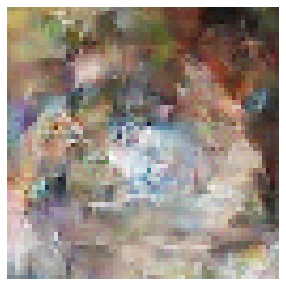

In [7]:
out = generator(noise)[0]
img = utils.tensor_to_image(out, ncol=1, padding=0)

plt.figure(figsize=(5,5))
plt.imshow(np.asarray(img))
plt.axis('off')
plt.show()

In [8]:
np.asarray(img).shape

(64, 64, 3)

# Generator Function

In [9]:
from inference import generate_background

In [10]:
out = generate_background(generator, device, truncated_normal=True)

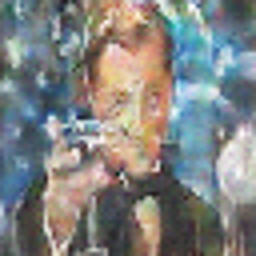

In [11]:
img = utils.tensor_to_image(out)
img.resize((256, 256))

### Aside: converting to numpy array (0-255)

In [12]:
print(type(img))
np_img = np.asarray(img)
print(np.min(np_img), np.max(np_img))
print(np.mean(np_img))

<class 'PIL.Image.Image'>
0 255
130.12141927083334


# Caption Function

In [52]:
from dataset import get_meme_caption_dataset
from captionmodel import RefinedLanguageModel

from settings import refined_model_vocab_embed_size, refined_model_decoder_hidden_size, refined_model_decoder_num_layers, refined_model_encoder_embed_size

MODEL_PARAMS_TO_LOAD = 'epoch-2-remote.ckpt'
MODEL_CKPT_PATH = f'./caption-model-v2-ckpts/{MODEL_PARAMS_TO_LOAD}'

dataset = get_meme_caption_dataset()
vocab_size = len(dataset.itos)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1
)

model = RefinedLanguageModel(
            vocab_embed_size=refined_model_vocab_embed_size,
            decoder_hidden_size=refined_model_decoder_hidden_size,
            decoder_num_layers=refined_model_decoder_num_layers,
            vocab_size=vocab_size,
            encoder_embed_size=refined_model_encoder_embed_size
        ).to(device)

model.load_state_dict(
    torch.load(MODEL_CKPT_PATH, map_location=torch.device(device))
)

model.eval()


Using cache found in /Users/harrymellsop/.cache/torch/hub/pytorch_vision_v0.10.0


RefinedLanguageModel(
  (encoder_cnn): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d

In [53]:
from inference import generate_caption_v2

caption = generate_caption_v2(torch.zeros((1, 3, 64, 64)), model, data_loader, dataset, device, 10)

 90%|█████████ | 9/10 [00:06<00:00,  1.48it/s]


In [54]:
caption

'i dont always does not do not a <UNK> <END>'

# Create the Meme!

In [55]:
from utils import Meme

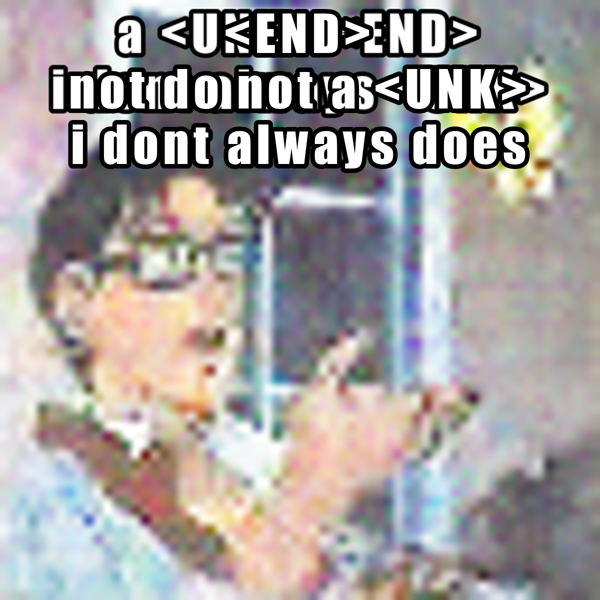

In [56]:
meme = Meme(caption, img)
meme.draw()

# All-in-one

In [57]:
from inference import generate_meme_v2

In [60]:
img = generate_meme_v2(generator, model, data_loader, device, dataset)

 80%|████████  | 8/10 [00:05<00:01,  1.54it/s]

tensor(0.4624, grad_fn=<MeanBackward0>)


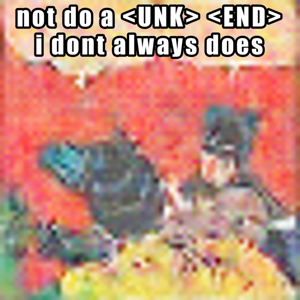

In [61]:
img.resize((300, 300))